In [1]:
import re
import numpy as np
import sys
import time
d_corpus = sc.textFile("../data/SmallTrainingData.txt", 1)
d_keyAndText = d_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
regex = re.compile('[^a-zA-Z]')
d_keyAndListOfWords = d_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

In [2]:
allWords = d_keyAndListOfWords.flatMap(lambda x: x[1]).map(lambda x: (x, 1))
from operator import add
allCounts = allWords.reduceByKey(add)

In [3]:
topWords = allCounts.top(20000, key=lambda x: x[1])
twentyK = sc.parallelize(range(20000))

In [4]:
dictionary = twentyK.map (lambda x : (topWords[x][0], x))

In [5]:
def buildArray (listOfIndices):
    returnVal = np.zeros (20000)
    for index in listOfIndices:
        returnVal[index] = returnVal[index] + 1
    mysum = np.sum (returnVal)
    returnVal = np.divide (returnVal, mysum)
    return returnVal

In [6]:
allWords = d_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))

In [7]:
allDictionaryWords = dictionary.join(allWords)

In [8]:
justDocAndPos = allDictionaryWords.map(lambda x: (x[1][1], x[1][0]))

In [9]:
allDictionaryWordsInEachDoc = justDocAndPos.groupByKey()

In [10]:
forCSV= allDictionaryWordsInEachDoc.mapValues(lambda x: np.array( list(x)))

In [11]:
tfs = allDictionaryWordsInEachDoc.map(lambda x: (x[0], buildArray(x[1])))

In [12]:
tfs.take(5)

[('AU35',
  array([0.11425061, 0.06511057, 0.02272727, ..., 0.        , 0.        ,
         0.        ])),
 ('AU85',
  array([0.11214496, 0.0553379 , 0.03770813, ..., 0.        , 0.        ,
         0.        ])),
 ('AU160',
  array([0.08426966, 0.04283708, 0.02457865, ..., 0.        , 0.        ,
         0.        ])),
 ('AU561',
  array([0.09657795, 0.03802281, 0.01977186, ..., 0.        , 0.        ,
         0.        ])),
 ('AU736',
  array([0.11322314, 0.0446281 , 0.01983471, ..., 0.        , 0.        ,
         0.        ]))]

In [12]:
def oneHotEncoding(ID):
    if re.compile('^AU').match(ID):
        return 1
    else:
        return 0

In [13]:
data = tfs.map(lambda x: (oneHotEncoding(x[0]), x[1]))

In [15]:
data.take(5)

[(1, array([0.11425061, 0.06511057, 0.02272727, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11214496, 0.0553379 , 0.03770813, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.08426966, 0.04283708, 0.02457865, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.09657795, 0.03802281, 0.01977186, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11322314, 0.0446281 , 0.01983471, ..., 0.        , 0.        ,
         0.        ]))]

In [16]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

In [17]:
dataLabel = data.map(lambda x: LabeledPoint(x[0], x[1]))

In [18]:
lrm = LogisticRegressionWithLBFGS.train(dataLabel, iterations=100)

In [16]:
test_corpus = sc.textFile("../data/TestingData.txt", 1)
test_keyAndText = test_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
regex = re.compile('[^a-zA-Z]')
test_keyAndListOfWords = test_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))
test_allWords = test_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))
test_allDictionaryWords = dictionary.join(test_allWords)
test_justDocAndPos = test_allDictionaryWords.map(lambda x: (x[1][1], x[1][0]))
test_allDictionaryWordsInEachDoc = test_justDocAndPos.groupByKey()
test_tfs = test_allDictionaryWordsInEachDoc.map(lambda x: (x[0], buildArray(x[1])))
test = test_tfs.map(lambda x: (oneHotEncoding(x[0]), x[1], x[0]))

In [17]:
test_num = test.count()

In [18]:
test_num

18724

In [19]:
testLabel = test.map(lambda x: (1, x[0])).reduceByKey(lambda x1, x2: x1 + x2).collect()[0][1]

In [20]:
testLabel

377

In [21]:
predTrue = test.map(lambda x: (x[0], lrm.predict(x[1])))

In [22]:
predTrue.take(5)

[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]

In [22]:
def getType1AndType2(true, pred):
    if true == 1.0 and pred == 1.0:
        TP = 1.0
    else:
        TP = 0.0
    if true == 0.0 and pred == 0.0:
        TN = 1.0
    else:
        TN = 0.0
    if true == 1.0 and pred == 0.0:
        FN = 1.0
    else:
        FN = 0.0
    if true == 0.0 and pred == 1.0:
        FP = 1.0
    else:
        FP = 0.0
    
    return np.array([TP, TN, FN, FP])

In [23]:
type1AndType2 = predTrue.map(lambda x: getType1AndType2(x[0], x[1]))
matric = type1AndType2.map(lambda x: (1, x)).reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 17.0 failed 1 times, most recent failure: Lost task 1.0 in stage 17.0 (TID 74, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Applications/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Applications/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Applications/spark/python/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/Applications/spark/python/pyspark/rdd.py", line 1861, in combineLocally
    merger.mergeValues(iterator)
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    for k, v in iterator:
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-21-693aba511b32>", line 1, in <lambda>
NameError: name 'lrm' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1124)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Applications/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Applications/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Applications/spark/python/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/Applications/spark/python/pyspark/rdd.py", line 1861, in combineLocally
    merger.mergeValues(iterator)
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    for k, v in iterator:
  File "/Applications/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-21-693aba511b32>", line 1, in <lambda>
NameError: name 'lrm' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1124)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
TP = matric[0][1][0]
TN = matric[0][1][1]
FN = matric[0][1][2]
FP = matric[0][1][3]

In [ ]:
def getF1score(TP, TN, FN, FP):
    if TP == 0:
        return 0
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * (precision * recall) / (precision + recall)
    return f_score

In [ ]:
f1_score = getF1score(TP, TN, FN, FP)

In [28]:
TP

349.0

In [29]:
TN

18338.0

In [30]:
FN

28.0

In [31]:
FP

9.0

In [32]:
print(f1_score)

0.9496598639455782


In [33]:
# task2

In [ ]:
import numpy as np

In [ ]:
scores = np.array([[1,2], [3,4], [5, 6], [7, 8]])
yi_scores = scores[np.arange(scores.shape[0]), [0, 1, 0, 1]]

In [ ]:
yi_scores

In [90]:
margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)

In [91]:
np.maximum(0, scores - np.matrix(yi_scores).T + 1)

matrix([[1, 2],
        [0, 1],
        [1, 2],
        [0, 1]])

In [92]:
num_train = scores.shape[0]
y = [0, 1, 0, 1]
margins[np.arange(num_train),y] = 0

In [93]:
margins

matrix([[0, 2],
        [0, 0],
        [0, 2],
        [0, 0]])

In [94]:
np.sum(margins, axis=1)

matrix([[2],
        [0],
        [2],
        [0]])

In [95]:
loss = np.mean(np.sum(margins, axis=1))
loss

1.0

In [101]:
binary = margins
binary[margins > 0] = 1
binary

matrix([[-1,  1],
        [ 0,  0],
        [-1,  1],
        [ 0,  0]])

In [104]:
row_sum = np.sum(binary, axis=1)
row_sum.T

matrix([[0, 0, 0, 0]])

In [98]:
binary[np.arange(num_train), y] = -row_sum.T

In [99]:
binary

matrix([[-1,  1],
        [ 0,  0],
        [-1,  1],
        [ 0,  0]])

In [ ]:
def getPreMargin(scores, yi_scores):
    # max(0, xw - xw_true) + delta
    return np.maximum(0.0, np.subtract(scores, yi_scores) + 1)

In [ ]:
def changeToZero(preMargins, y):
    preMargins[y] = 0.0
    return preMargins

In [117]:
# Set initial weights (200000, 2)
W = np.full((20000, 2), 0.0001)
# Set initial dW as zero
dW = np.zeros(W.shape)
# To get scores do dot product of X (n, 200000) and W (200000, 2)
scores = data.map(lambda x: (x[0], x[1], np.dot(x[1], W)))
# Select one correctly categorized point.
yi_scores = scores.map(lambda x: (x[0], x[1], x[2], x[2][x[0]]))
# Calculate margin and ignore the correctlly classified points by setting them 0.
preMargins = yi_scores.map(lambda x: (x[0], x[1], getPreMargin(x[2], x[3])))
margins = preMargins.map(lambda x: (x[0], x[1], changeToZero(x[2], x[0])))
# Calculate loss by taking mean of distance from mergin to point
loss = margins.map(lambda x: (1, (np.sum(x[2]), 1.0)))\
            .reduceByKey(lambda x1, x2: (x1[0] + x2[0], x1[1] + x2[1]))
loss.take(5)
#loss_pair = loss.collect()[0][1]
#loss = loss_pair[0] / loss_pair[1]

[(1, (3442.0, 3442.0))]

In [53]:
def getMax(y, wx):
    # max(0, xw - xw_true) + delta
    return np.maximum(0.0, (1 - y*wx))

In [54]:
def biggerThanOne(y, wx, x):
    if (y * wx) > 1.0:
        return np.zeros(20000)
    else:
        return -y*x

In [26]:
n = data.count()

In [42]:
W = np.full((20000), 1.5)
dW = np.zeros(W.shape)
reg = 0.5
scores = data.map(lambda x: (x[0], x[1], np.dot(x[1], W)))
yi_score = scores.map(lambda x: (1, getMax(x[0], x[2])))\
               .reduceByKey(lambda x1, x2: x1 + x2).collect()
loss = 0.5 * reg * np.dot(W, W) + yi_score[0][1] / n
dW = scores.map(lambda x: (1, biggerThanOne(x[0], x[2], x[1])))\
            .reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()
dW = (dW[0][1]/n).T

In [43]:
dW

array([-0.00204832, -0.00096721, -0.00044807, ...,  0.        ,
        0.        ,  0.        ])

In [55]:
def svm_lossWd(W, reg):
    dW = np.zeros(W.shape)
    scores = data.map(lambda x: (x[0], x[1], np.dot(x[1], W)))
    yi_score = scores.map(lambda x: (1, getMax(x[0], x[2])))\
               .reduceByKey(lambda x1, x2: x1 + x2).collect()
    loss = 0.5 * reg * np.dot(W, W) + yi_score[0][1] / n
    dW = scores.map(lambda x: (1, biggerThanOne(x[0], x[2], x[1])))\
                .reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()
    dW = np.add(reg*W, (dW[0][1]/n).T)
    return loss, dW

In [119]:
def getBinary(margins):
    margins[margins > 0.0] = 1.0
    return margins

In [120]:
def changeToRowSum(binary, y, row_sum):
    binary[y] = - row_sum
    return binary

In [121]:
def getDw(x, b):
    return np.array([x * b[0], x * b[1]])

In [122]:
num_train = data.count()

In [123]:
num_train

3442

In [124]:
reg = 0.5

In [130]:
binary = margins.map(lambda x: (x[0], x[1], getBinary(x[2])))
row_sum = binary.map(lambda x: (x[0], x[1], x[2], np.sum(x[2])))
trueBinary = row_sum.map(lambda x: (x[0], x[1], changeToRowSum(x[2], x[0], x[3])))
dW = trueBinary.map(lambda x: (1,  getDw(x[1], x[2])))\
                .reduceByKey(lambda x1, x2: np.add(x1, x2))
dW.collect()
#
# Average
#dW /= num_train
#dW += reg * W

[(1, array([[-2.57944468e+02, -1.20423699e+02, -1.09292952e+02, ...,
          -2.35248715e-02, -1.92710818e-02, -9.70278304e-03],
         [ 2.57944468e+02,  1.20423699e+02,  1.09292952e+02, ...,
           2.35248715e-02,  1.92710818e-02,  9.70278304e-03]]))]

In [134]:
dW.collect()[0][1].T

array([[-2.57944468e+02,  2.57944468e+02],
       [-1.20423699e+02,  1.20423699e+02],
       [-1.09292952e+02,  1.09292952e+02],
       ...,
       [-2.35248715e-02,  2.35248715e-02],
       [-1.92710818e-02,  1.92710818e-02],
       [-9.70278304e-03,  9.70278304e-03]])

In [56]:
def svm_loss(W, reg):
    # Set initial dW as zero
    dW = np.zeros(W.shape)
    # To get scores do dot product of X (n, 200000) and W (200000, 2)
    scores = data.map(lambda x: (x[0], x[1], np.dot(x[1], W)))
    # Select one correctly categorized point.
    yi_scores = scores.map(lambda x: (x[0], x[1], x[2], x[2][x[0]]))
    # Calculate margin and ignore the correctlly classified points by setting them 0.
    preMargins = yi_scores.map(lambda x: (x[0], x[1], getPreMargin(x[2], x[3])))
    margins = preMargins.map(lambda x: (x[0], x[1], changeToZero(x[2], x[0])))
    # Calculate loss by taking mean of distance from mergin to point
    loss = margins.map(lambda x: (1, (np.sum(x[2]), 1.0)))\
                .reduceByKey(lambda x1, x2: (x1[0] + x2[0], x1[1] + x2[1]))
    loss = loss.collect()[0][1]
    loss = loss[0] / loss[1]
    # Set binary by setting one if the distance from margin is over than zero.
    binary = margins.map(lambda x: (x[0], x[1], getBinary(x[2])))
    # Set the correctly classified case to negative one or zero
    row_sum = binary.map(lambda x: (x[0], x[1], x[2], np.sum(x[2])))
    trueBinary = row_sum.map(lambda x: (x[0], x[1], changeToRowSum(x[2], x[0], x[3])))
    # Get derivative of yx part, if j = yi, -x, otherwise x 
    dW = trueBinary.map(lambda x: (1,  getDw(x[1], x[2])))\
                    .reduceByKey(lambda x1, x2: np.add(x1, x2))
    dW = dW.collect()[0][1].T
    # Average
    dW /= num_train
    dW += reg * W
    
    return loss, dW

In [57]:
# Set initial weights (200000, 2)
W = np.full((20000), 1.5)
num_iteration = 100
learningRate = 0.01
count = 0
reg = 0.1
loss_prev =  sys.float_info.max
while num_iteration > count:
    
    loss, dW = svm_lossWd(W, reg)
    
    W = np.subtract(W, learningRate*dW)
    
    # Bold Driver logic
    if loss < loss_prev:
        learningRate *= 1.05
    else:
        learningRate *= 0.5

    print("Iteration: ", count)
    print("W: " ,W)
    print("Loss: ", loss)
    
    loss_prev = loss

    count += 1

Iteration:  0
W:  [1.4985 1.4985 1.4985 ... 1.4985 1.4985 1.4985]
Loss:  2250.978500871586
Iteration:  1
W:  [1.49692658 1.49692658 1.49692658 ... 1.49692658 1.49692658 1.49692658]
Loss:  2246.480750871579
Iteration:  2
W:  [1.49527621 1.49527621 1.49527621 ... 1.49527621 1.49527621 1.49527621]
Loss:  2241.76767181281
Iteration:  3
W:  [1.49354524 1.49354524 1.49354524 ... 1.49354524 1.49354524 1.49354524]
Loss:  2236.829455384141
Iteration:  4
W:  [1.49172983 1.49172983 1.49172983 ... 1.49172983 1.49172983 1.49172983]
Loss:  2231.6558977158234
Iteration:  5
W:  [1.48982596 1.48982596 1.48982596 ... 1.48982596 1.48982596 1.48982596]
Loss:  2226.2363888070813
Iteration:  6
W:  [1.48782945 1.48782945 1.48782945 ... 1.48782945 1.48782945 1.48782945]
Loss:  2220.5599022893334
Iteration:  7
W:  [1.48573593 1.48573593 1.48573593 ... 1.48573593 1.48573593 1.48573593]
Loss:  2214.614985618539
Iteration:  8
W:  [1.48354082 1.48354082 1.48354082 ... 1.48354082 1.48354082 1.48354082]
Loss:  2208.

Iteration:  71
W:  [0.78241784 0.7800966  0.77898194 ... 0.7780199  0.7780199  0.7780199 ]
Loss:  646.9135295875418
Iteration:  72
W:  [0.75685864 0.75425261 0.75300119 ... 0.75192112 0.75192112 0.75192112]
Loss:  606.3018205582116
Iteration:  73
W:  [0.73092174 0.7280267  0.72663651 ... 0.72543666 0.72543666 0.72543666]
Loss:  566.3730881524941
Iteration:  74
W:  [0.70464723 0.70145943 0.69992865 ... 0.69860747 0.69860747 0.69860747]
Loss:  527.246913120904
Iteration:  75
W:  [0.6780793  0.67459547 0.67292254 ... 0.67147866 0.67147866 0.67147866]
Loss:  489.04178403801563
Iteration:  76
W:  [0.65126627 0.64748367 0.64566727 ... 0.64409958 0.64409958 0.64409958]
Loss:  451.8737905618044
Iteration:  77
W:  [0.62426053 0.62017703 0.61821613 ... 0.61652372 0.61652372 0.61652372]
Loss:  415.8552409733156
Iteration:  78
W:  [0.59711852 0.59273258 0.59062645 ... 0.5888087  0.5888087  0.5888087 ]
Loss:  381.0932243242881
Iteration:  79
W:  [0.56990054 0.56521133 0.56295957 ... 0.56101612 0.56

In [138]:
num_train

3442

In [139]:
#W_true = W[np.arange(len(W)), np.argmax(W, axis = 1)]
label = data.map(lambda x: (1, x[0])).reduceByKey(lambda x1, x2: x1 + x2).collect()
label[0][1]

74

In [140]:
# test_corpus = sc.textFile("../data/TestingData.txt", 1)
# test_keyAndText = test_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
# regex = re.compile('[^a-zA-Z]')
# test_keyAndListOfWords = test_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

# test_allWords = test_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))
# test_allDictionaryWords = dictionary.join(test_allWords)
# test_justDocAndPos = test_allDictionaryWords.map(lambda x: (x[1][1], x[1][0]))
# test_allDictionaryWordsInEachDoc = test_justDocAndPos.groupByKey()
# test_tfs = test_allDictionaryWordsInEachDoc.map(lambda x: (x[0], buildArray(x[1])))
# test = test_tfs.map(lambda x: (oneHotEncoding(x[0]), x[1], x[0]))

In [163]:
prediction = test.map(lambda x: (x[0], np.dot(x[1], W), x[2]))\
#                 .map(lambda x: (x[0], np.argmin(x[1]), x[2]))
#prediction = test.map(lambda x: (x[0], np.dot(x[1], W), x[2]))


In [164]:
prediction.take(5)

[(1, array([0.09179355, 0.05675537]), 'AU67'),
 (1, array([0.11133536, 0.06824803]), 'AU87'),
 (1, array([0.08995693, 0.05454217]), 'AU329'),
 (1, array([0.09344337, 0.05836716]), 'AU360'),
 (1, array([0.10300479, 0.06283603]), 'AU365')]

In [155]:
def getType1AndType2(true, pred):
    if true == 1 and pred == 1:
        TP = 1.0
    else:
        TP = 0.0
    if true == 0 and pred == 0:
        TN = 1.0
    else:
        TN = 0.0
    if true == 1 and pred == 0:
        FN = 1.0
    else:
        FN = 0.0
    if true == 0 and pred == 1:
        FP = 1.0
    else:
        FP = 0.0
    
    return np.array([TP, TN, FN, FP])

In [156]:
type1AndType2 = prediction.map(lambda x: (x[2], getType1AndType2(x[0], x[1])))
matric = type1AndType2.map(lambda x: (1, x[1])).reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()

In [157]:
type1AndType2.take(5)

[('AU67', array([1., 0., 0., 0.])),
 ('AU87', array([1., 0., 0., 0.])),
 ('AU329', array([1., 0., 0., 0.])),
 ('AU360', array([1., 0., 0., 0.])),
 ('AU365', array([1., 0., 0., 0.]))]

In [158]:
TP = matric[0][1][0]
TN = matric[0][1][1]
FN = matric[0][1][2]
FP = matric[0][1][3]

In [162]:
FP

18346.0

In [150]:
def getF1score(TP, TN, FN, FP):
    if TP == 0:
        return 0
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * (precision * recall) / (precision + recall)
    return f_score

In [151]:
f1_score = getF1score(TP, TN, FN, FP)

In [152]:
f1_score

0

In [105]:
#task 3

In [106]:
data.take(3)

[(1, array([0.11425061, 0.06511057, 0.02272727, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11214496, 0.0553379 , 0.03770813, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.08426966, 0.04283708, 0.02457865, ..., 0.        , 0.        ,
         0.        ]))]

In [27]:
def getXtX(x):
    return  np.array([np.multiply(x, m) for m in x])

In [28]:
XtX = data.map(lambda x: (1, getXtX(x[1])))\
        .reduceByKey(lambda x1, x2: np.add(x1, x2))

In [29]:
XtX.take(1)

KeyboardInterrupt: 

In [121]:
a = np.arange(20000)
[np.multiply(a, i) for i in a]


[array([0, 0, 0, ..., 0, 0, 0]),
 array([    0,     1,     2, ..., 19997, 19998, 19999]),
 array([    0,     2,     4, ..., 39994, 39996, 39998]),
 array([    0,     3,     6, ..., 59991, 59994, 59997]),
 array([    0,     4,     8, ..., 79988, 79992, 79996]),
 array([    0,     5,    10, ..., 99985, 99990, 99995]),
 array([     0,      6,     12, ..., 119982, 119988, 119994]),
 array([     0,      7,     14, ..., 139979, 139986, 139993]),
 array([     0,      8,     16, ..., 159976, 159984, 159992]),
 array([     0,      9,     18, ..., 179973, 179982, 179991]),
 array([     0,     10,     20, ..., 199970, 199980, 199990]),
 array([     0,     11,     22, ..., 219967, 219978, 219989]),
 array([     0,     12,     24, ..., 239964, 239976, 239988]),
 array([     0,     13,     26, ..., 259961, 259974, 259987]),
 array([     0,     14,     28, ..., 279958, 279972, 279986]),
 array([     0,     15,     30, ..., 299955, 299970, 299985]),
 array([     0,     16,     32, ..., 319952, 319968,

In [15]:
n = data.count()

In [17]:
mu = data.map(lambda x: (1, x[1]))\
        .reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()[0][1]
mu = np.divide(mu, n)
variance = data.map(lambda x: (1, np.square(np.subtract(x[1], mu))))\
                .reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()[0][1]
variance = np.divide(variance, n)

In [18]:
label = [(i, variance[i]) for i in range(len(variance))]

In [19]:
sortedColumn = sorted(label, key = lambda x: x[1], reverse=True)

In [22]:
sortedColumn

[(0, 0.00043670232993840464),
 (1, 0.0001937044383787087),
 (3, 0.00011662394322768178),
 (1964, 9.797605112682486e-05),
 (2, 8.432656418458153e-05),
 (15, 7.655931529815696e-05),
 (4, 6.993639795993735e-05),
 (10, 6.452716388406792e-05),
 (6, 6.183945649366855e-05),
 (5, 5.7626723125639074e-05),
 (18, 5.2701419401923905e-05),
 (8, 3.715214322091366e-05),
 (9, 3.540232830737658e-05),
 (37, 3.210157951401877e-05),
 (12, 3.184198503977083e-05),
 (43, 3.0830188835048545e-05),
 (7, 2.1641914680787575e-05),
 (751, 2.024600161463502e-05),
 (21, 1.9731825884440194e-05),
 (16, 1.9452864299265874e-05),
 (60, 1.8964753874369072e-05),
 (24, 1.8471137447680258e-05),
 (11, 1.832771666044287e-05),
 (13, 1.723103083904697e-05),
 (14, 1.6809828813590084e-05),
 (19, 1.520098979850587e-05),
 (27, 1.5138657812050483e-05),
 (2376, 1.4920153120231273e-05),
 (210, 1.3559725739675092e-05),
 (292, 1.3234479480232281e-05),
 (138, 1.2756900855650708e-05),
 (22, 1.0480595065877644e-05),
 (17, 1.0148253963748033e

In [117]:
import matplotlib.pyplot as plt

In [119]:
sortedVariance = np.array([sortedColumn[i][1] for i in range(len(sortedColumn))])

In [120]:
sortedVariance

array([4.36702330e-04, 1.93704438e-04, 1.16623943e-04, ...,
       2.58938400e-10, 1.93133807e-10, 1.93133807e-10])

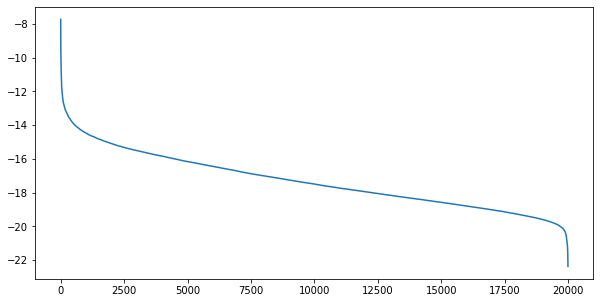

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(sortedVariance)), np.log(sortedVariance))
plt.show()

In [125]:
topColumn = sortedColumn[:10000]
columnIdx = [topColumn[i][0] for i in range(len(topColumn))]

In [132]:
selectedData = data.map(lambda x: (x[0], x[1][columnIdx]))

In [133]:
selectedData.take(5)

[(1, array([0.11425061, 0.06511057, 0.01781327, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11214496, 0.0553379 , 0.02546523, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.08426966, 0.04283708, 0.03195225, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.09657795, 0.03802281, 0.02357414, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11322314, 0.0446281 , 0.01404959, ..., 0.        , 0.        ,
         0.        ]))]